In [1]:
from pynq.overlays.base import BaseOverlay
from pynq.lib.video import *
base = BaseOverlay("base.bit")

In [17]:
if (base.switches[0].read()==0 and base.switches[1].read()==0) :
    base.leds[0].on()
elif (base.switches[0].read() == 0 and base.switches[1].read() == 1) :
    base.leds[1].on()
elif (base.switches[0].read() == 1 and base.switches[1].read() == 0) :
    base.leds[2].on()
elif (base.switches[0].read() == 1 and base.switches[1].read() == 1) :
    base.leds[3].on()#注意python的elif和and和C语言不一样
#btn = base_overlay.buttons[0].read()#按键
#print(btn)
#sw = base_overlay.switches[0].read()
#print(sw)
#base_overlay.switches[0].wait_for_value(1)#等待拨码值为1才执行下一句
#print("switch on")
#base_overlay.buttons[0].wait_for_value(1)#等待按键值为1才执行下一句
#print("btn pressed")
base.rgbleds[4].write(0)
# import time
# while 1:
#     if base.buttons[0].read() == 1 :#按键
#         for i in range(0,8):
#             base.rgbleds[4].write(i)
            
#             time.sleep(0.1)


In [18]:
# base.leds[0].off()

In [2]:
import serial
import serial.tools.list_ports
import time
import math
import cv2 as cv
import numpy as np
import threading

In [3]:
class LeArm:
    def __init__(self, ser):
        self.ser = ser
        self.head = [0x55, 0x55]
        self.x3D = 0
        self.y3D = 0
        self.z3D = 0

    def reset(self):
        t = 1000
        cmd = [{'ID': i, 'value': 1500} for i in range(1, 7)]
        self.controlMOVE(cmd, t)
        time.sleep(t/1000)

    def stop(self):
        Myinput = [0x55, 0x55, 2, 7]
        self.ser.write(Myinput)

    def controlMOVE(self, cmd, ctime=400):
        #example : cmd =[{ID:1,value:1500},]
        # self.stop()
        lenCmd = len(cmd)
        Myinput = [0x55, 0x55, lenCmd * 3 + 5, 3, lenCmd,
                   ctime & 0xff, ctime >> 8]

        for c in range(lenCmd):
            Myinput.append(cmd[c]['ID'])
            Myinput.append(cmd[c]['value'] & 0xff)
            Myinput.append(cmd[c]['value'] >> 8)

        self.ser.write(Myinput)
        self.ser.write([1, 1, 1])  # 垃圾数据以清零

    def InverseKinematics(self, x, y, alpha, ctime=1000):
        limtheta = 82
        l2 = 0.17
        l1 = 0.088
        l0 = 0.1035

        m = l2 * math.cos(alpha) - x
        n = l2 * math.sin(alpha) - y
        k = (l1 * l1 - l0 * l0 - m * m - n * n) / 2 / l0  # 中间变量
        a = m * m + n * n  # 解一元二次方程
        b = -2 * n * k
        c = k * k - m * m

        if (b * b - 4 * a * c <= 0):  # b ^ 2 - 4ac 小于0即无实根，直接返回
            return 1  # 返回1，作错误

        theta1 = (-b - math.sqrt(
            b * b - 4 * a * c)) / 2 / a  # 求解二元一次方程，只取其中一个，另外一个解是(-b + sqrt(b * b - 4 * a * c)) / 2 / a
        theta1 = math.asin(theta1) * 180 / math.pi  # 将弧度换算为角度
        # print('th1=', theta1)
        if (theta1 > limtheta):
            theta1 = limtheta  # 限制最大角度为正负90度
            return 1
        elif (theta1 < -limtheta):
            theta1 = -limtheta
            return 1

        k = (l0 * l0 - l1 * l1 - m * m - n * n) / 2 / l1
        a = m * m + n * n  # 解一元二次方程
        b = -2 * n * k
        c = k * k - m * m

        if (b * b - 4 * a * c <= 0):  # 方程无实根就不做求解
            return 2  # 返回2， 作错误标记

        s1ps2 = (-b + math.sqrt(b * b - 4 * a * c)) / 2 / a
        s1ps2 = math.asin(s1ps2) * 180 / math.pi  # 将弧度换算为角度

        theta2 = s1ps2 - theta1
        # print('th2=', theta2)
        if (theta2 > limtheta):
            theta2 = limtheta
            return 2  # 限制最大角度为正负90度
        elif (theta2 < -limtheta):
            theta2 = -limtheta  # 限制最大角度为正负90度
            return 2
        theta3 = alpha * 180 / math.pi - theta1 - theta2  # 求5号舵机角度
        # print('th3=',theta3)
        if (theta3 > limtheta):
            theta3 = limtheta
            return 3
        elif (theta3 < -limtheta):
            theta3 = -limtheta  # 控制舵机的最大角度180
            return 3
        # // 将求得的三个角度，转换为对应的脉宽，然后控制舵机转动。
        # // 需要注意的是机械臂的舵机开机后为1500位置。我们将此位置定为0度，即0度为180度舵机的90度位置。
        # // 因舵机安装方向的不同，舵机角度的正负方向要根据舵机安装方向调整
        #               // 将舵机角度转为公式为
        #               // (2000 * 角度 / 180 + 500)
        #               // 上式的角度的范围是0 - 180度
        cmd = [[{'ID': 5, 'value': int(2000 * (90.0 + theta1) / 180.0 + 500.0)}],
               [{'ID': 4, 'value': int(2000 * (90.0 - theta2) / 180.0 + 500.0)}],
               [{'ID': 3, 'value': int(2000 * (90.0 - theta3) / 180.0 + 500.0)}]]
        for i in cmd:
            # print(i)
            self.controlMOVE(i, ctime)
        return 0  # 一切正常返回0

    def point3D(self, y, x, z, ctime=900):
        self.z3D = z
        self.x3D = y
        self.y3D = x
        r = math.sqrt(x ** 2 + y ** 2)
        theta0 = math.atan(y / x) / math.pi * 180

        i = math.pi
        while (self.InverseKinematics(z, r, i, ctime) != 0):
            i -= 0.01
            if (i <= 0):
                break
        # print('i=', i)
        cmd = [{'ID': 6, 'value': int(2000 * (90.0 - theta0) / 180.0 + 500.0)}]
        self.controlMOVE(cmd, ctime)
        time.sleep(ctime / 1000)

    def grab(self):
        cmd = [{'ID': 1, 'value': 600}]
        self.controlMOVE(cmd)
        time.sleep(0.4)
        self.point3D(self.x3D, self.y3D, self.z3D - 0.077) #会更新z3D
        time.sleep(0.1)

        cmd = [{'ID': 1, 'value': 1500}]
        self.controlMOVE(cmd)
        time.sleep(0.4)
        self.point3D(self.x3D, self.y3D, 0.1)

    def relax(self):
        cmd = [{'ID': 1, 'value': 600}]
        self.controlMOVE(cmd)
        time.sleep(0.4)

    def hold(self):
        cmd = [{'ID': 1, 'value': 1500}]
        self.controlMOVE(cmd)

In [4]:
# monitor configuration: 640*480 @ 60Hz
Mode = VideoMode(640,480,24)
hdmi_out = base.video.hdmi_out
hdmi_out.configure(Mode,PIXEL_BGR)
hdmi_out.start()

In [5]:
# monitor (output) frame buffer size
frame_out_w = 1920
frame_out_h = 1080
# camera (input) configuration
frame_in_w = 640
frame_in_h = 480

In [15]:
# Display webcam image via HDMI Out
# if (ret):
#     outframe = hdmi_out.newframe()
#     outframe[0:480,0:640,:] = frame_vga[0:480,0:640,:]
#     hdmi_out.writeframe(outframe)
# else:
#     raise RuntimeError("Failed to read from camera.")

In [6]:
ser = serial.Serial('/dev/learm', 9600)

In [7]:
frame_in_w = 640
frame_in_h = 480
learm = LeArm(ser)
cap = cv.VideoCapture(0)
cap.set(cv.CAP_PROP_FRAME_WIDTH, frame_in_w);
cap.set(cv.CAP_PROP_FRAME_HEIGHT, frame_in_h);

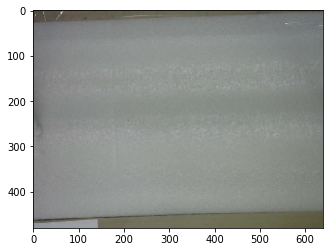

In [9]:
class ShapeAnalysis:
    def __init__(self, cap):
        self.elements = []
        self.contours = []
        self.shapes = {'triangle': 0, 'rectangle': 0, 'polygons': 0, 'circles': 0, 'square': 0}
        self.TARGET_COLORS = {"Red": (161, 60, 52), "Blue": (53, 99, 147),
                              "Orange": (148, 124, 35), "Purple": (146, 98, 128)}  # RGB值

#     def imageShow(self):
#         while 1:
#             cv.imshow("input image", self.resultFrame)
#             cv.waitKey(400)
    def analysis(self, frame):
        self.elements = []
        h, w, ch = frame.shape

        # 二值化图像
        print("start to detect lines...\n")
        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        # gray = cv.GaussianBlur(gray, (5, 5), 0)
        ret, binary = cv.threshold(gray, 130, 255, cv.THRESH_BINARY_INV)

        m = np.zeros_like(binary)
        m[80:430, 80:520] = 255
        dst = cv.bitwise_and(binary, m)
        result =  cv.bitwise_and(frame,frame,mask= dst)
        _,self.contours, hierarchy = cv.findContours(dst, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

        for cnt in range(len(self.contours)):
            # 提取与绘制轮廓
            if cv.contourArea(self.contours[cnt]) < 1500:
                continue
            cv.drawContours(result, self.contours, cnt, (0, 255, 0), 2)

            # 轮廓逼近
            epsilon = 0.01 * cv.arcLength(self.contours[cnt], True)
            approx = cv.approxPolyDP(self.contours[cnt], epsilon, True)

            # 分析几何形状
            corners = len(approx)
            shape_type = ""
            (x, y, w, h) = cv.boundingRect(approx)
            ar = w / float(h)
            if ar < 0.8 or ar  >1.3:
                shape_type = "rectangle"
            elif corners <= 5:
                count = self.shapes['triangle']
                count = count + 1
                self.shapes['triangle'] = count
                shape_type = "triangle"
            elif 5 < corners <= 12:
                (x, y, w, h) = cv.boundingRect(approx)
                ar = w / float(h)
                shape_type = "square"  # if ar >= 0.95 and ar <= 1.05 else "rectangle"
                count = self.shapes[shape_type]
                count = count + 1
                self.shapes[shape_type] = count

            elif corners >= 12:
                count = self.shapes['circles']
                count = count + 1
                self.shapes['circles'] = count
                shape_type = "circle"
            try:
                # 求解中心位置
                mm = cv.moments(self.contours[cnt])
                cx = int(mm['m10'] / mm['m00'])
                cy = int(mm['m01'] / mm['m00'])
                cv.circle(result, (cx, cy), 3, (0, 0, 255), -1)

                # 颜色分析
                color = frame[cy][cx]
                color_str = "(" + str(color[0]) + ", " + str(color[1]) + ", " + str(color[2]) + ")"

                cargoColor = color[::-1]  # BGR转RGB
                differences = [[color_difference(cargoColor, target_value), target_name] for target_name, target_value
                               in self.TARGET_COLORS.items()]
                differences.sort()
                my_color_name = differences[0][1]
                # 计算面积与周长
                p = cv.arcLength(self.contours[cnt], True)
                area = cv.contourArea(self.contours[cnt])
                cv.putText(result, str(shape_type + '  '+str(my_color_name)), (cx - 30, cy - 20),
                           cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
                print("周长: %.3f, 面积: %.3f 颜色: %s 形状: %s " % (p, area, my_color_name, shape_type))
                element = {'shape': shape_type, 'cx': cx, 'cy': cy, 'color': color, 'colorName': my_color_name}
                self.elements.append(element)
                

            except Exception as e:
                pass
        outframe = hdmi_out.newframe()
        outframe[0:480,0:640,:] = result[0:480,0:640,:]
        hdmi_out.writeframe(outframe)


def color_difference(color1, color2):
    return sum([abs(component1 - component2) for component1, component2 in zip(color1, color2)])



ld = ShapeAnalysis(cap)

flag = 1
m = np.array([[7.95564899e-06, 5.78018820e-04, -1.69083080e-01],
              [-6.06313506e-04, -4.14747646e-05, 4.60930914e-01]])


trianglePlace = [-0.29, 0.01]
circlePlace = [-0.29, 0.11]
squarePlace = [-0.2, 0.01]
rectanglePlace = [-0.2, 0.11]

learm.reset()

#     ld.thr.start()


while 1:
    if (base.switches[1].read()==1):
        flag=1
        for i in range(10):
            ret, frame = cap.read()
        ld.analysis(frame)
    # element = {'shape': shape_type, 'cx': cx, 'cy': cy, 'color': color}
    # {'triangle': 0, 'rectangle': 0, 'polygons': 0, 'circles': 0, 'square': 0}
        print(ld.elements)
        useShape = base.switches[0].read()
        for ele in ld.elements:
            point = np.zeros([2, 1])
            point[0] = ele['cy']
            point[1] = ele['cx']

            if(base.switches[1].read()==0):
                break
            shape = ele['shape']
            colorName = ele['colorName']
            if useShape:
                if shape == "circle":
                    ax = circlePlace
                elif shape == 'rectangle':
                    ax = rectanglePlace
                elif shape == 'square':
                    ax = squarePlace
                else:
                    ax = trianglePlace
            else:
                if colorName == "Red":
                    ax = trianglePlace
                elif colorName == "Blue":
                    ax = circlePlace
                elif colorName == "Orange":
                    ax = squarePlace
                else:
                    ax = rectanglePlace

            cir = np.matmul(m[:, 0:2], point).T[0] + m[:, 2]
            print('shape=', ele['shape'], ' cx=', ele['cx'], ' cy=', ele['cy'], ' color=', ele['color'], ' colorName=',
                  colorName,
                  ' \t cmd = ', cir)
            #抓取
            learm.relax()
            learm.point3D(cir[0], cir[1], 0.012, 900)
            learm.grab()
            time.sleep(1)
            #摆放
            learm.point3D(ax[0], ax[1], 0.1)
            time.sleep(1)
            learm.relax()
        #复原
        learm.reset()
        time.sleep(5)
        for i in range(10):
            ret, frame = cap.read()
        ret, frame = cap.read()

        ld.analysis(frame)
    else:
        if flag==1:
            flag=0
            learm.reset()
        time.sleep(2)
        for i in range(10):
            ret, frame = cap.read()
        outframe = hdmi_out.newframe()
        outframe[0:480,0:640,:] = frame[0:480,0:640,:]
        hdmi_out.writeframe(outframe)
        
        

# cv.destroyAllWindows()

